# Elena's paper

Started to play with Elena's paper:
[Link to the paper](https://www.frontiersin.org/journals/oncology/articles/10.3389/fonc.2022.1028871/full)

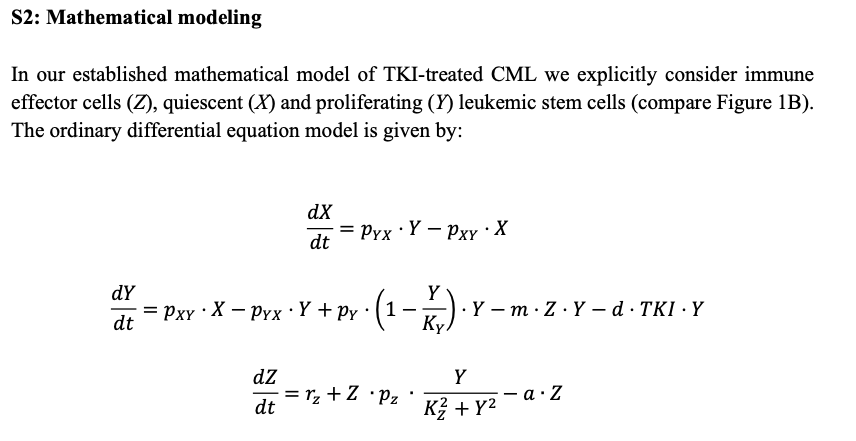

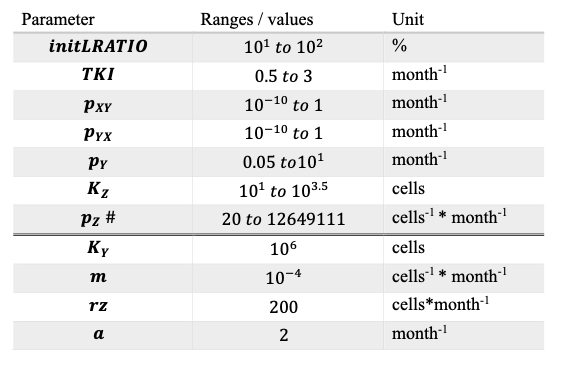

In [1]:
import pandas as pd
import plotnine as p9
import numpy as np
from scipy.integrate import odeint
from plotnine import ggplot, aes, geom_point, geom_line, facet_wrap
p9.theme_set(p9.theme_bw())

def dict_to_tuple(x):
    return tuple(x.values())


In [2]:
def get_p_and_y0(df, d = 1, i = 1):
    pp = df.iloc[i].to_dict()
    p = {key: pp[key] for key in ['Pz', 'Pyx', 'Pxy', 'TKI', 'Kz', 'Ky', 'Py', 'm', 'rz', 'a']}
    p['d'] = d
    y_0 = {key: pp[key] for key in ['X(0)', 'Y(0)', 'Z(0)']}
    return p, y_0


params_df = pd.read_csv('ParameterSets.csv')

p, y0 = get_p_and_y0(params_df, 1)
params_df


,Unnamed: 0,PatID,Pz,Pyx,Pxy,TKI,Kz,Ky,Py,m,rz,a,X(0),Y(0),Z(0),HalfingDoseTime,CessationTime
0,1,002-095,918.212826,0.003674,0.043994,1.953862,217.221302,1000000.0,0.973924,0.0001,200,2,78382.854581,938723.700292,100.048931,61.545205,73.545205
1,2,002-109,23083.129866,0.032012,0.066389,0.500185,1870.604823,1000000.0,0.001000,0.0001,200,2,216186.368403,448352.579679,102.642186,120.295890,132.295890
2,3,002-123,10092.226454,0.082485,0.081357,0.687386,796.735702,1000000.0,0.003026,0.0001,200,2,13010.901299,12832.979836,164.393817,61.709589,73.709589
3,4,003-133,345.298359,0.000673,0.030023,0.897634,62.137465,1000000.0,0.200074,0.0001,200,2,17996.873639,802776.842858,100.021511,96.164384,108.164384
4,5,003-141,306.696917,0.001098,0.000037,0.675628,1272.917683,1000000.0,0.527287,0.0001,200,2,312316.113662,10632.126673,101.442441,118.882192,130.882192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,74,218-105,227.900944,0.000629,0.021212,0.540216,44.762743,1000000.0,0.371630,0.0001,200,2,9617.275519,324397.497286,100.035139,117.172603,129.172603
74,75,218-113,707.776619,0.000947,0.082137,0.936809,109.291797,1000000.0,0.004144,0.0001,200,2,10082.133001,874421.411603,100.040488,52.898630,64.898630
75,76,230-140,4355.988897,0.003152,0.081907,1.065387,898.457630,1000000.0,0.470243,0.0001,200,2,33711.053422,876082.957124,100.249225,76.832877,88.832877
76,77,230-142,1445.428430,0.000161,0.000878,0.794767,323.840047,1000000.0,0.679967,0.0001,200,2,33011.628854,180303.529279,100.402444,60.263014,72.263014


In [3]:
def cml_model(y, t, Pz, Pyx, Pxy, TKI, Kz, Ky, Py, m, rz, a, d):
    X, Y, Z = y
    dX = Pyx * Y - Pxy * X
    dY = Pxy * X - Pyx * Y + Py * (1 - Y / Ky) * Y - m * Z * Y - d * TKI * Y
    dZ = rz + Z * Pz * (Y / (Kz ** 2 + Y ** 2)) - a * Z
    return (dX, dY, dZ)


In [4]:
ii = tuple(range(0, len(params_df) - 1))
ii = tuple(range(0, 9))

In [5]:

t = np.arange(0.0, 100, 0.01)
result_list = []

for i in ii:
    p, y0 = get_p_and_y0(params_df, i = i)
    result = odeint(cml_model, 
                    dict_to_tuple(y0), 
                    t,
                    args=dict_to_tuple(p))
    df = pd.DataFrame(result, columns = ['X', 'Y', 'Z'])
    df = df.assign(t = t)
    df['PatID'] = i
    result_list.append(df)

result = pd.concat(result_list, ignore_index=True)
result['PatID'] = result['PatID'].astype('category')


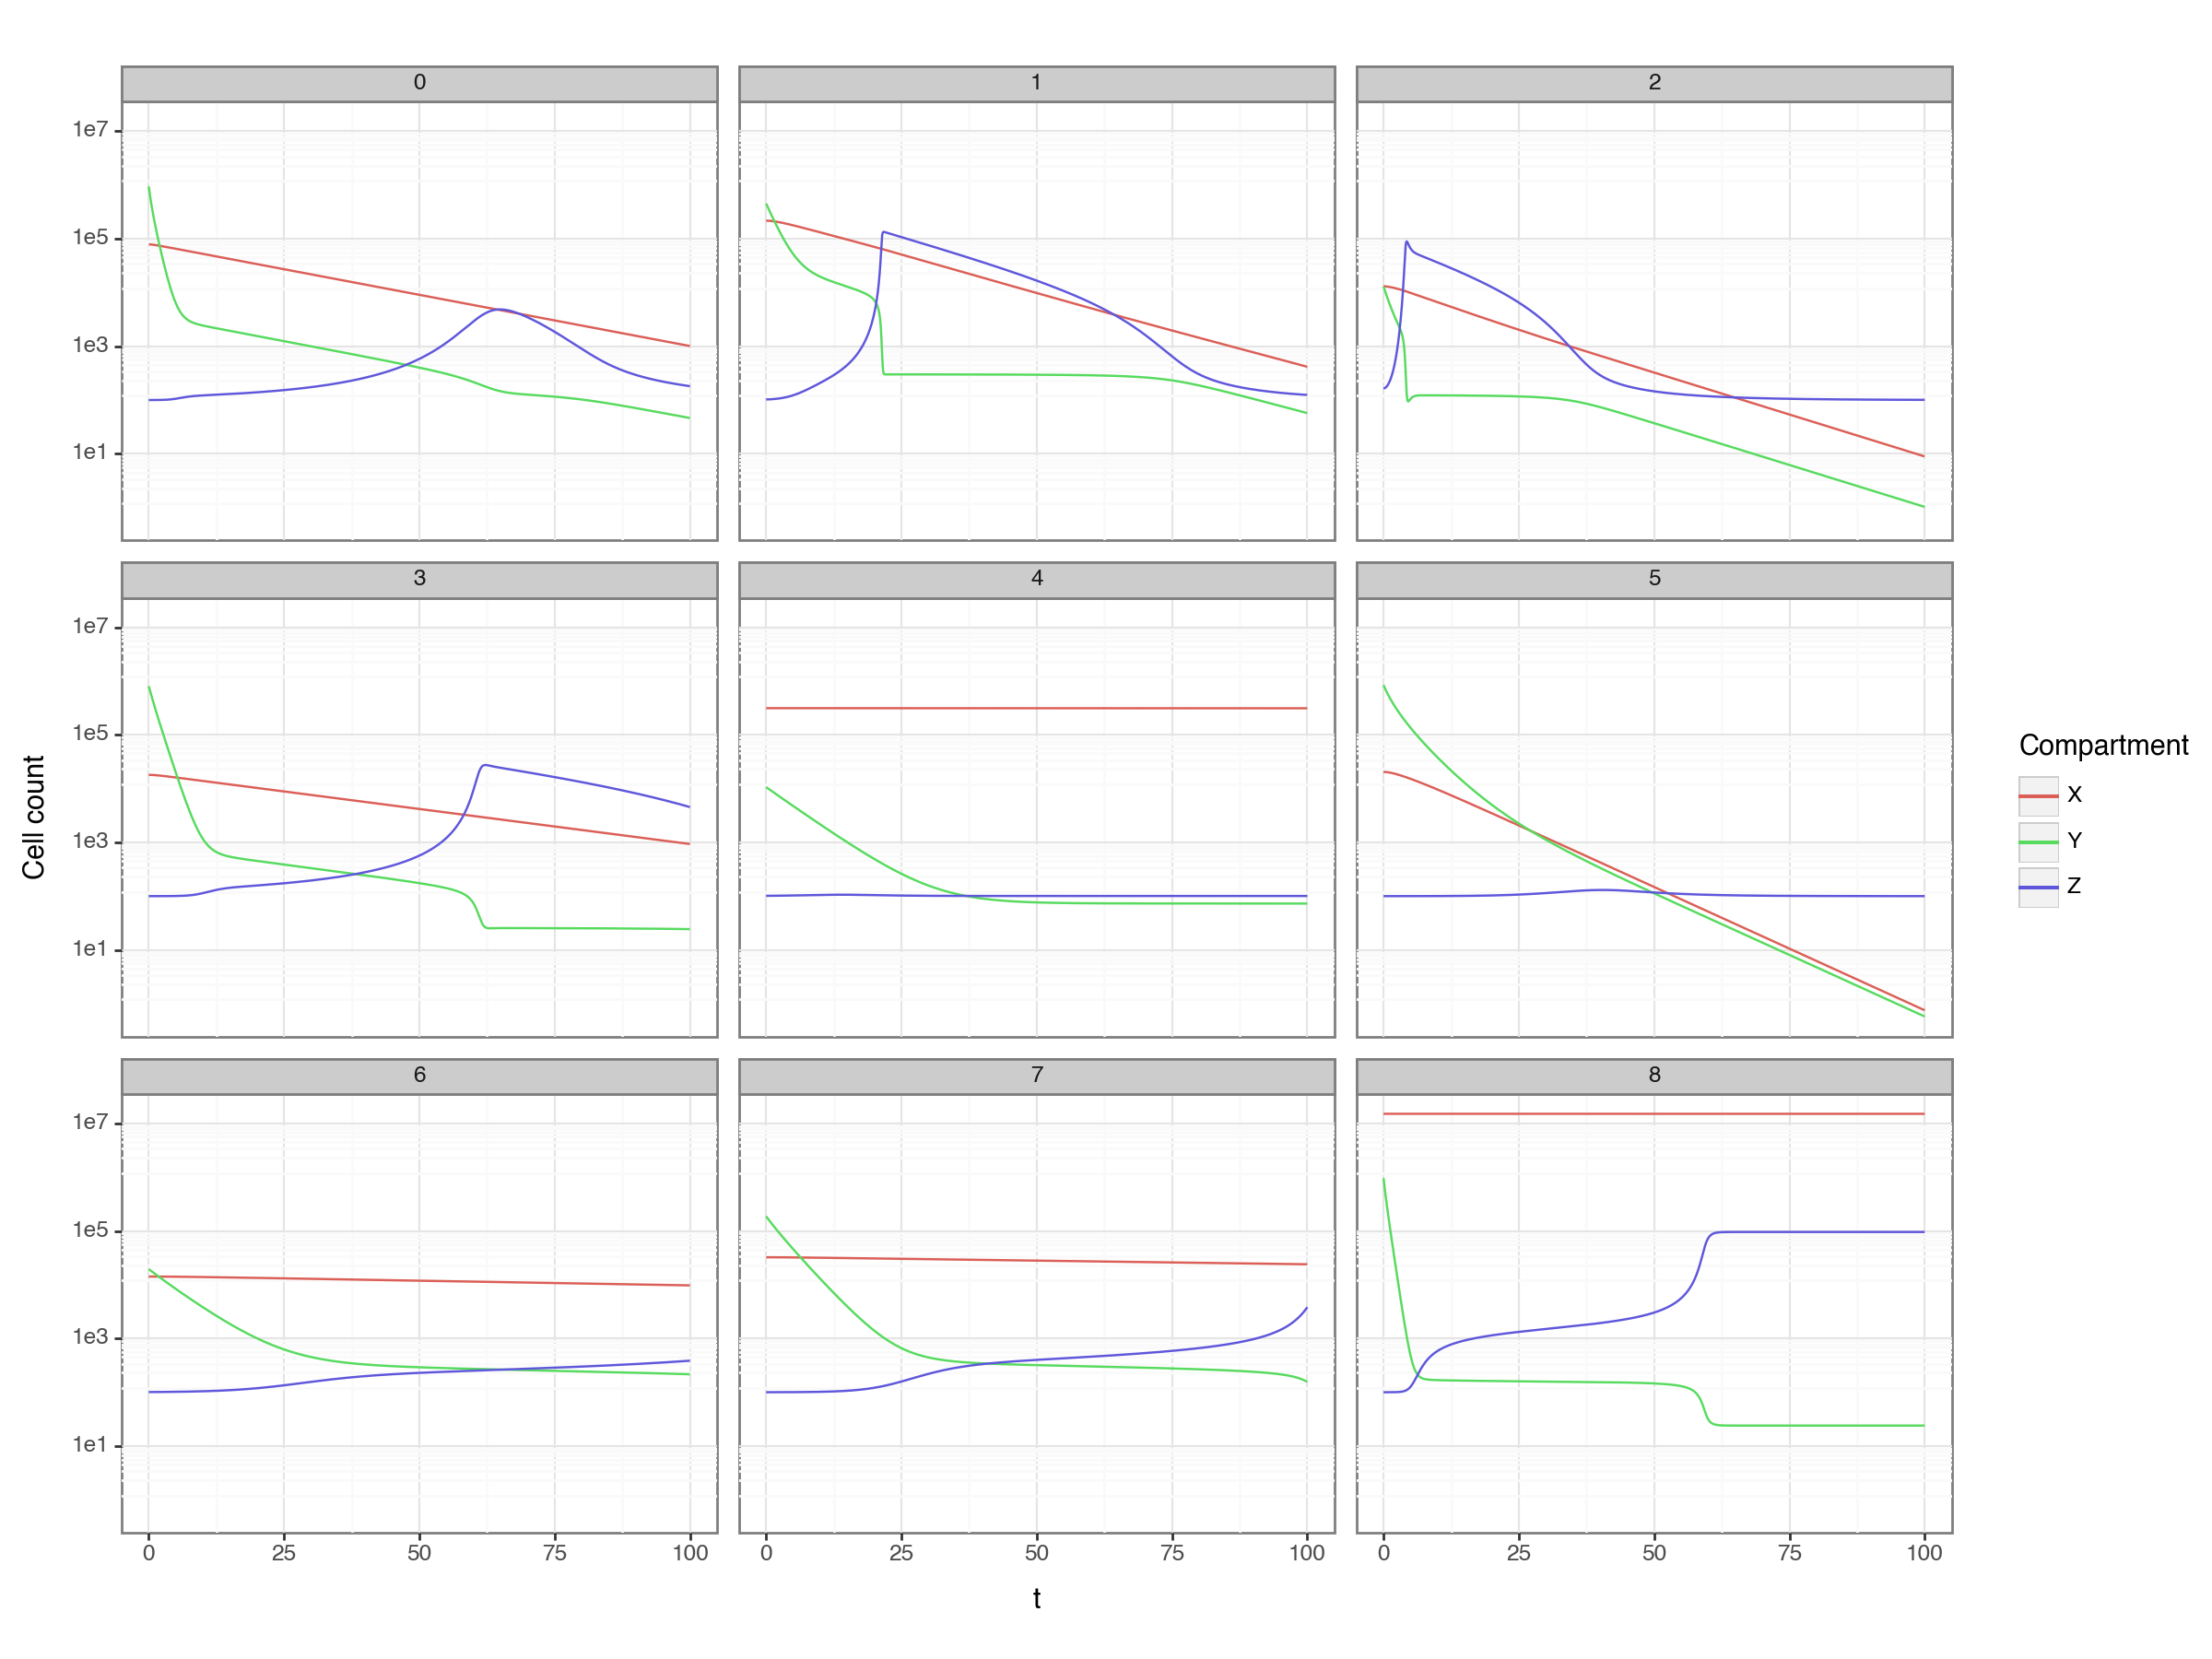

<Figure Size: (1200 x 900)>

In [6]:
result_long = pd.melt(result, 
                      id_vars = ['t', 'PatID'], 
                      value_vars = ['X', 'Y', 'Z'],
                      value_name = 'cell_count')
(
    ggplot(result_long, aes('t', 'cell_count', color = 'variable')) + 
    geom_line() + 
    facet_wrap('PatID')+ p9.scale_y_continuous(trans='log10') +
    p9.theme(figure_size=(12,9)) +
    p9.labs(y='Cell count', color = 'Compartment')
)



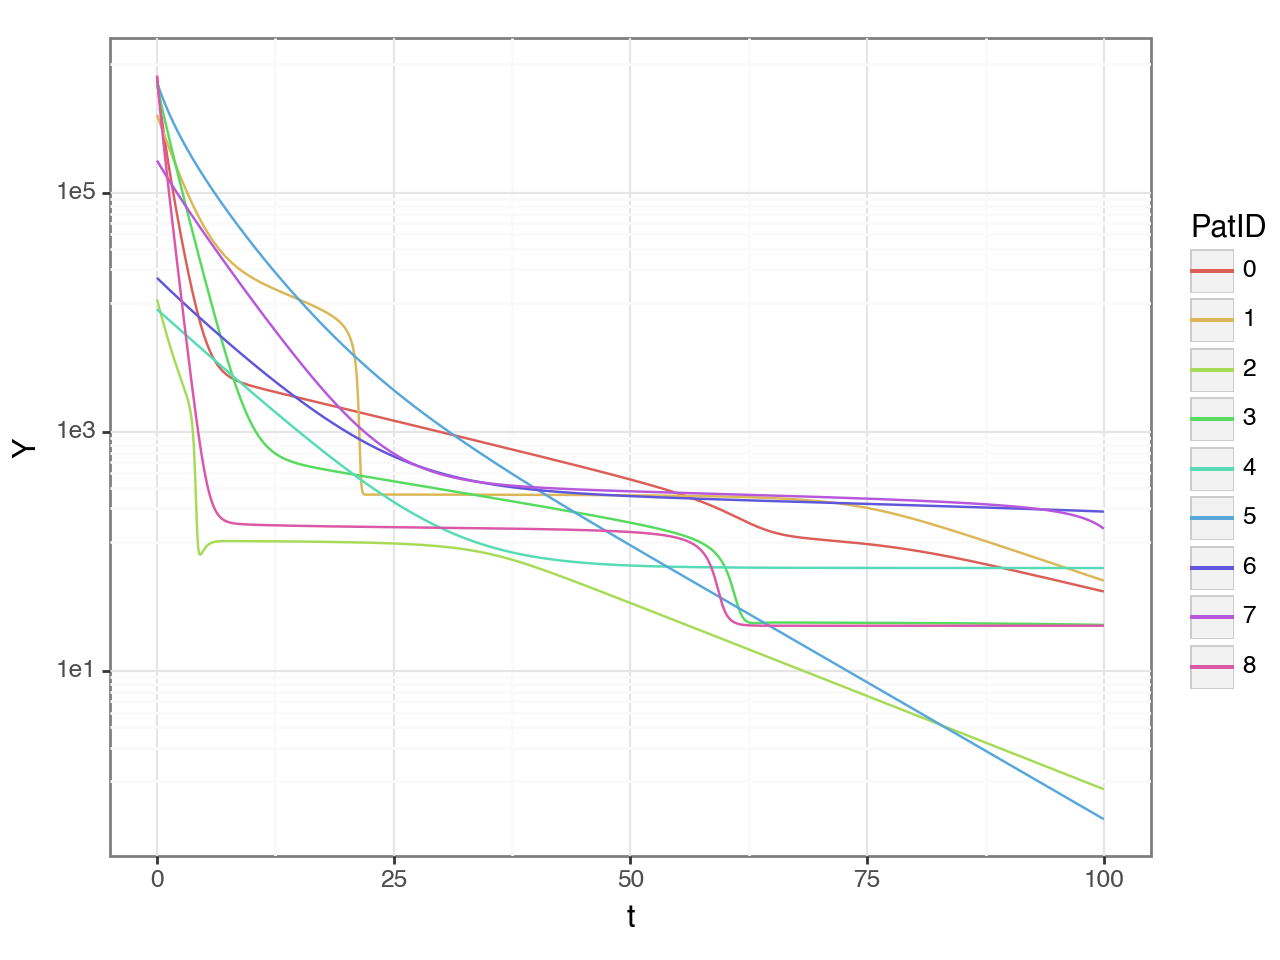

<Figure Size: (640 x 480)>

In [7]:
(
    ggplot(result, aes('t', 'Y', color = 'PatID')) + 
    geom_line() + p9.scale_y_continuous(trans='log10')
)


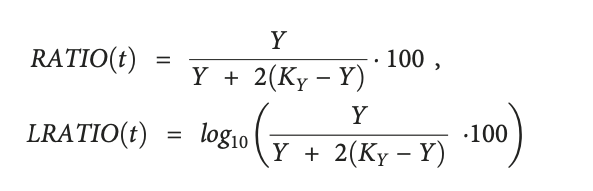

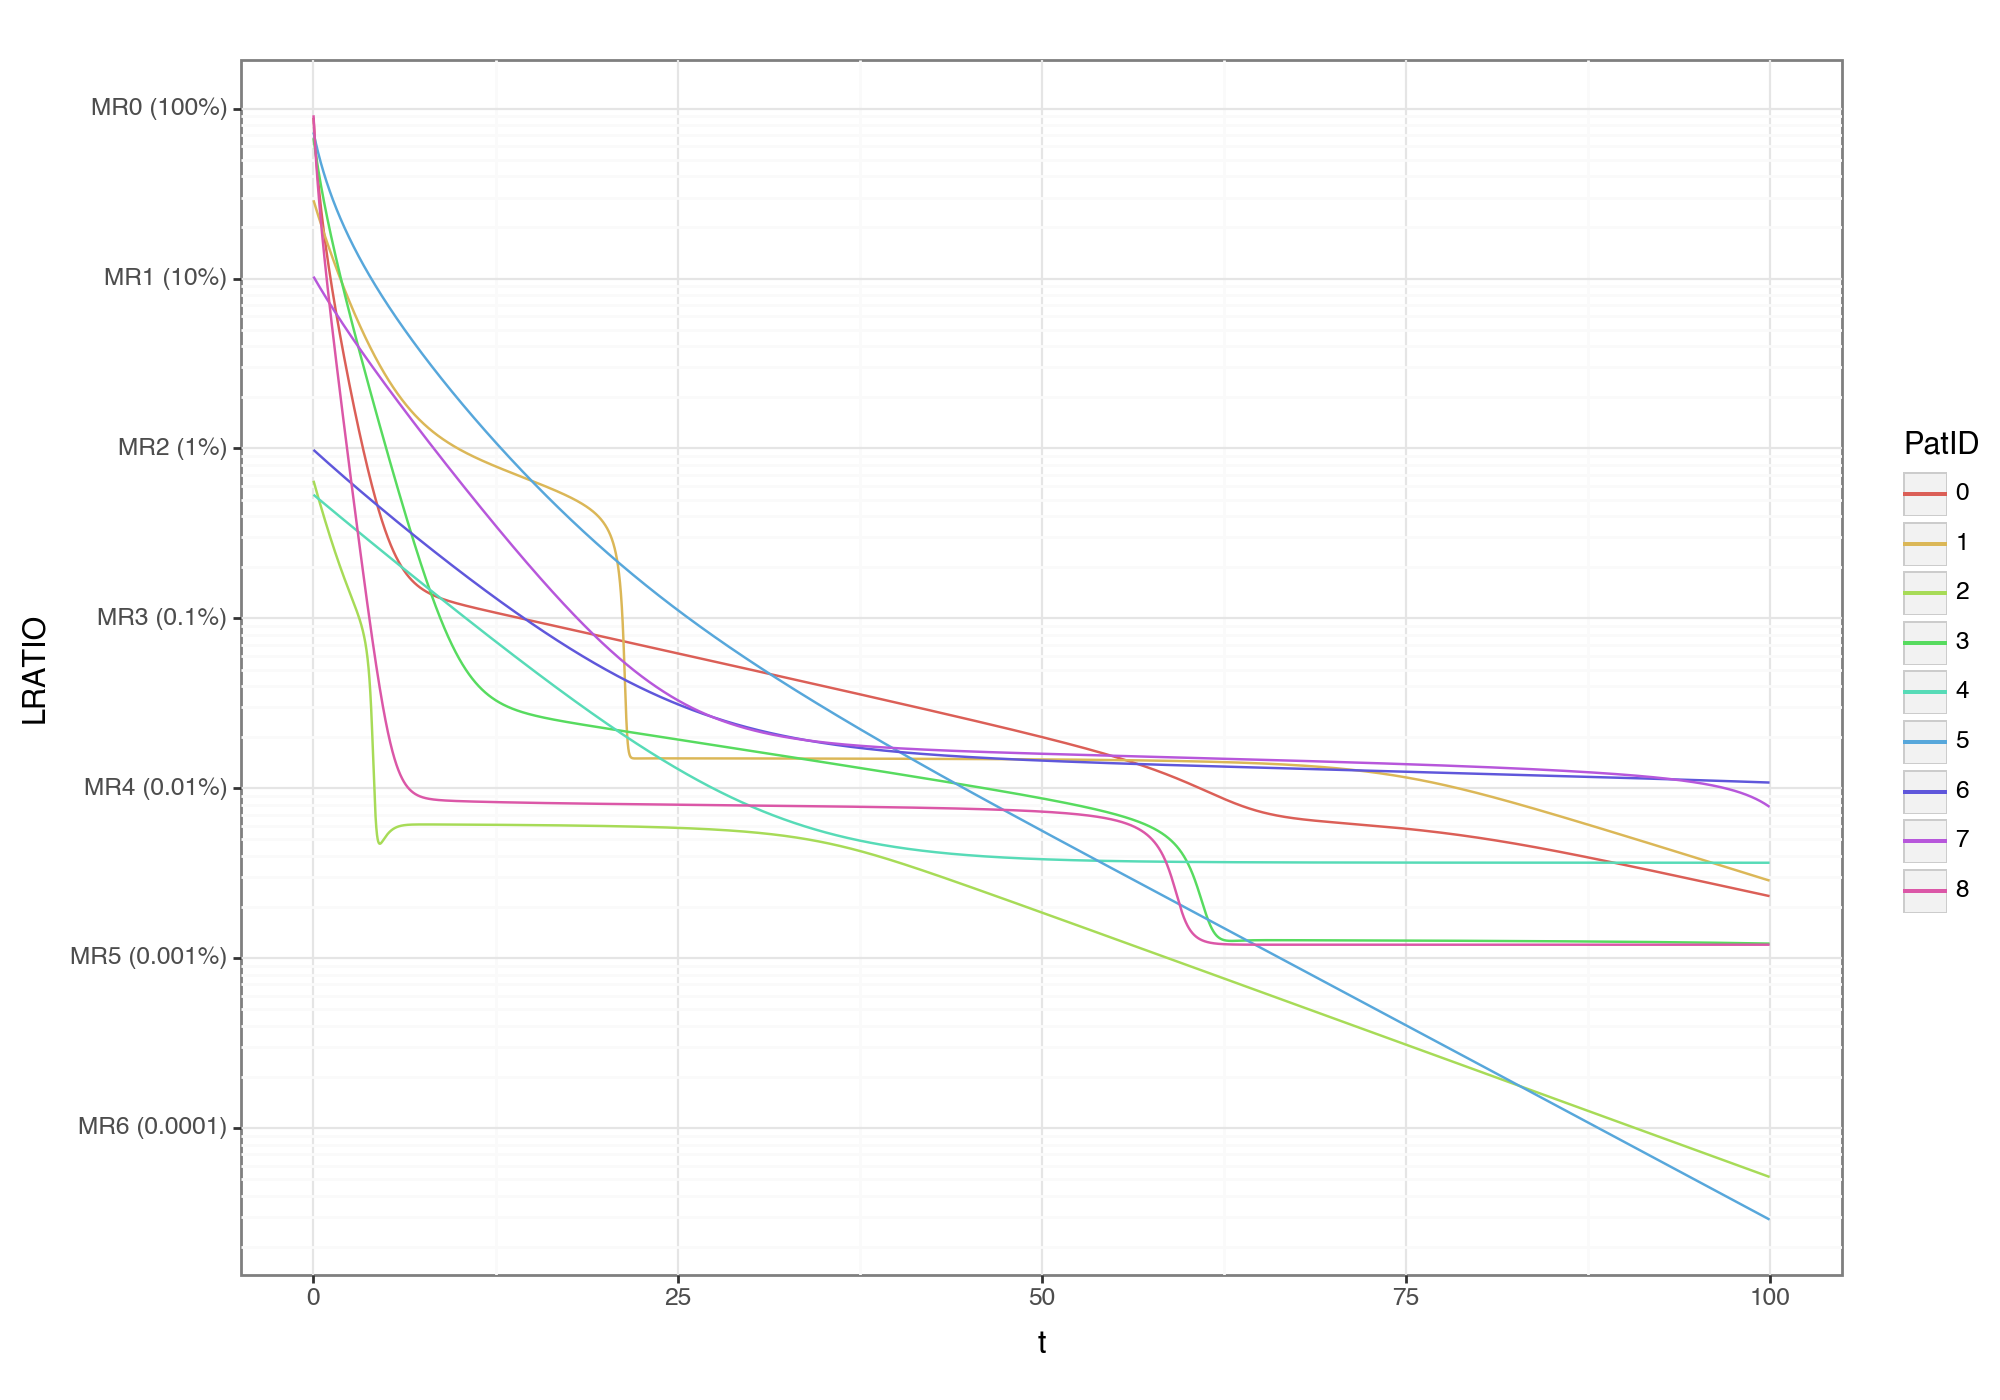

<Figure Size: (1000 x 700)>

In [8]:
def LRATIO(Y, KY=1e6):
    return Y / (Y + 2 * (KY - Y))

result['LRATIO'] = LRATIO(result["Y"])

(
    ggplot(result, aes('t', 'LRATIO', color='PatID')) + 
    geom_line() + p9.scale_y_continuous(trans='log10', 
                                        breaks=(1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6), 
                                        labels=('MR0 (100%)', 'MR1 (10%)', 'MR2 (1%)', 'MR3 (0.1%)', 'MR4 (0.01%)', 'MR5 (0.001%)', 'MR6 (0.0001)')) +
    p9.theme(figure_size=(10, 7))
)
